In [1]:
#Loading required packages
import networkx as nx
import matplotlib.pyplot as plt
#%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality
from networkx.algorithms import closeness_centrality
import itertools
from matplotlib import rc

# Initial analysis of the network.

In [152]:
G = nx.read_graphml('trading_floor.xml')

In [153]:
pos={}
for node in G.nodes():
    pos[str(node)]=(G.nodes[node]["y_pos"],G.nodes[node]["x_pos"])
ai_attribs=np.array(list(nx.get_node_attributes(G,'ai').values()))  

In [4]:
#Check whether the graph is connected
nx.is_connected(G)

True

In [5]:
#What is the network's diameter and average shortest path length?
print(nx.diameter(G))
print(nx.average_shortest_path_length(G))

9
4.698462041884817


The average path length of the network is 4.69, which is a relatively long value given the network's 192 nodes. Nine is the diameter of the network, which may indicate the presence of distant nodes.

Retrieve the degree values associated with each node.

In [6]:
degree_values=[i[1] for i in G.degree() ]
degree_values=np.array(degree_values)
#What is the average degree of the network?
np.mean(degree_values)

4.0

Visualize degree centralities.

<Figure size 864x720 with 0 Axes>

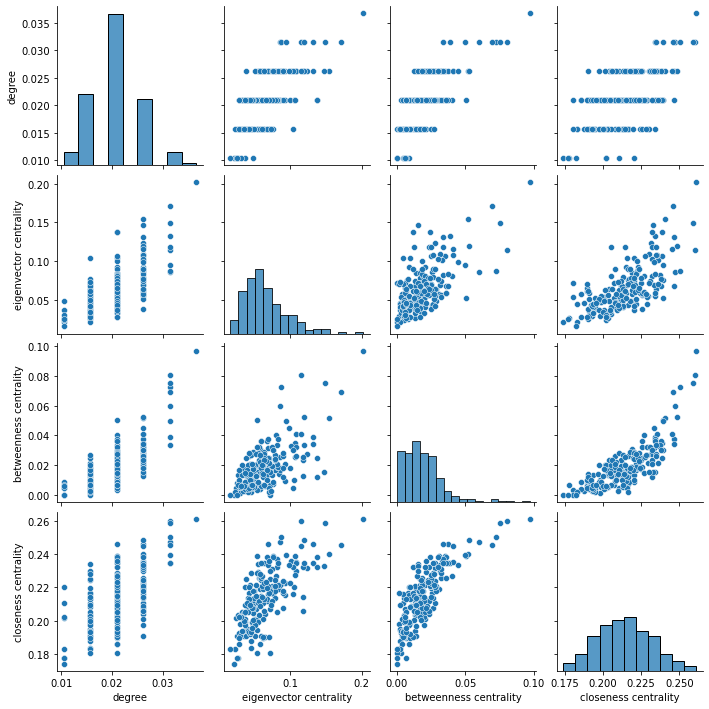

In [25]:
fig=plt.figure(figsize=(12,10))
degree = degree_centrality(G)
ec = eigenvector_centrality(G)
bc = betweenness_centrality(G)
cs=closeness_centrality(G)
df = pd.DataFrame({'degree': degree, 'eigenvector centrality': ec,
                   'betweenness centrality': bc,'closeness centrality':cs})
df.corr()
# --+ scatter plot matrix
sns.pairplot(df)

**Inferences derived from the charts:**

0. The centrality distributions are similar to the watts strogatz graph model.
1. The network is not random, as there is no perfect correlation between centrality measures. While there is a trend between d c and other centrality measures , the magnitude is quite large. This indicates the possibility of network phenomena such as core-periphery structure, communities, homophily, or the presence of hubs.
2. The distributions of degree-centrality and closeness-centrality are similar and exhibit the bell curve. On the other hand, the narrowness around the mean is different: more nodes have a good c_c score than a good d_c score.
3. The betweeness-centrality distribution is skewed to the left, resulting in a small number of nodes with high b_c scores. This could indicate the presence of hubs, or traders occupying a strategic position within the network.
4. In many cases, the b_c and e_c scores differ, implying that a node's position on the shortest paths does not necessarily imply that it is connected to other influencial nodes to the same extent.

By simulating a connected Watts–Strogatz small-world graph, we can compare the 'traders' network to the small-world network.

In [8]:
G_t = nx.connected_watts_strogatz_graph(192, 4, 0.3, seed=None)

In [9]:
degree_values_=[i[1] for i in G_t.degree() ]
degree_values_=np.array(degree_values_)
#What is the average degree of the simulated network?
np.mean(degree_values_)

4.0

<Figure size 864x720 with 0 Axes>

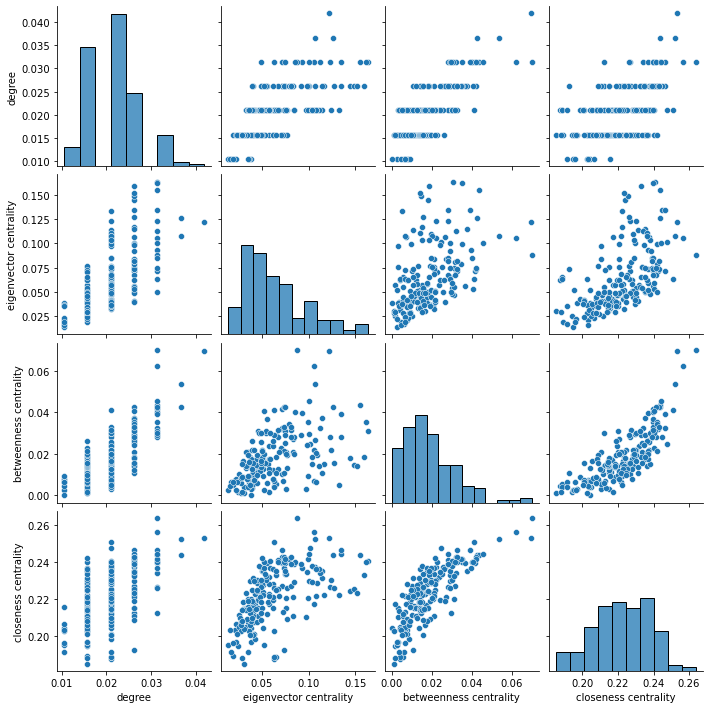

In [10]:
fig=plt.figure(figsize=(12,10))
degree = degree_centrality(G_t)
ec = eigenvector_centrality(G_t)
bc = betweenness_centrality(G_t)
cs=closeness_centrality(G_t)
df_sim = pd.DataFrame({'degree': degree, 'eigenvector centrality': ec,
                   'betweenness centrality': bc,'closeness centrality':cs})
df_sim.corr()
# --+ scatter plot matrix
sns.pairplot(df_sim)

The above illustration supports the small-world hypothesis.

In [29]:
df['ai_attribs']=ai_attribs

In [30]:
df=df.sort_values(by='eigenvector centrality', ascending=False)

In [31]:
#Find top 10 most influencial nodes
top_10_ec=df[:20]

In [32]:
#What is their opinion on AI?
average_sentiment_of_influencers=np.mean(top_10_ec.ai_attribs)
average_sentiment_of_influencers

4.45

In [11]:
df.iloc[:5,:]

,degree,eigenvector centrality,betweenness centrality,closeness centrality
0,0.020942,0.042633,0.026085,0.216553
1,0.015707,0.024720,0.008319,0.190429
2,0.015707,0.028654,0.002745,0.192735
3,0.020942,0.040677,0.012934,0.206934
4,0.026178,0.057392,0.030629,0.219288


The sentiment of the top 20 influential traders is below average, which has a negative effect on the whole network 

# How do traders' opinions fit into the knowledge exchange network and the trading floor's layout?

 Let's run the Girvan-Newman algorithm and visualise the network to determine whether communities are defined by physical allocation. Then consider how opinions differ between and within communities.

In [54]:
from networkx.algorithms.community import girvan_newman, modularity
solutions = girvan_newman(G)

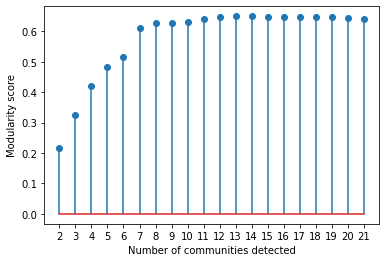

In [52]:
# alternative paritioning solutions to consider
k = 20
# register modularity scores
modularity_scores = dict()
# iterate over solutions
for community in itertools.islice(solutions, k):
    solution = list(sorted(c) for c in community)
    score = modularity(G, solution)
    modularity_scores[len(solution)] = score
# plot modularity data
fig = plt.figure()
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()

In [53]:
#The chosen number of communities is 7
solutions = girvan_newman(G)
k=6
for communities in itertools.islice(solutions, k):
    solution=(tuple(sorted(c) for c in communities))

In [54]:
#Assign colors to corresponding groups
node_groups=solution
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    elif node in node_groups[1]:
        color_map.append('green')
    elif node in node_groups[2]:
        color_map.append('purple')
    elif node in node_groups[3]:
        color_map.append('grey')
    elif node in node_groups[4]:
        color_map.append('red')
    elif node in node_groups[5]:
        color_map.append('orange')  
    elif node in node_groups[6]:
        color_map.append('pink') 

In [57]:
#How many traders per group?
group_sizes=[len(i) for i in node_groups]
group_sizes

[19, 18, 15, 39, 63, 8, 30]

Average sentiment in the network

In [350]:
np.mean(ai_attribs)

4.6875

Average sentiment with breakdown into groups

In [58]:
ai_group=[]
for group in node_groups:
    scores=[G.nodes[str(i)]["ai"] for i in group]
    avg=np.mean(scores)
    std=np.std(scores)
    ai_group.append((avg,std))      

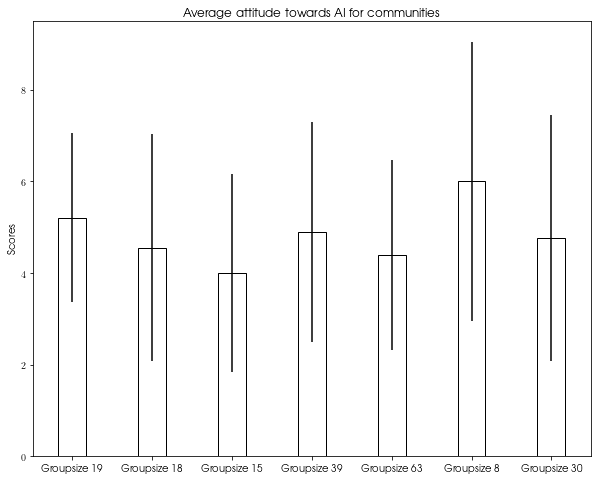

In [62]:
means=[ai_group[i][0] for i in range(len(ai_group)) ]
stds=[ai_group[i][1] for i in range(len(ai_group)) ]
plt.style.use('seaborn-bright')
rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']})
rc('text', usetex=True)
groups = ['Groupsize '+str(i) for i in group_sizes]
width = 0.35       # the width of the bars: can also be len(x) sequence
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.bar(groups, means, width, yerr=stds,
      color='white', edgecolor='k')
ax.set_ylabel('Scores')
ax.set_title('Average attitude towards AI for communities ')
plt.show()

**Insights and assumptions derived from the Figure:**
1. There is no strong correlation between group size and sentiment score.
2. The smallest group is the most enthusiastic about artificial intelligence. One possibility is that this group of traders is highly skilled and sees potential benefits from AI. They are more likely to communicate with one another because they share a positive attitude toward artificial intelligence, but they are incapable of convincing colleagues from other groups. Alternatively, they are unwilling to share information due to a rivalry.
3. Approximately 33% of all traders are members of the community, which has a below-average score (4.40 against 4.68). By influencing community sentiment, the network's overall score could be improved.
4. Communities have a wide range of viewpoints.

## Visualize the network based on the physical allocation (tables)

In [71]:
sizes=np.array(list(ec.values()))

In [72]:
labels={}
for i in G.nodes():
    labels[i]=G.nodes[str(i)]["ai"]

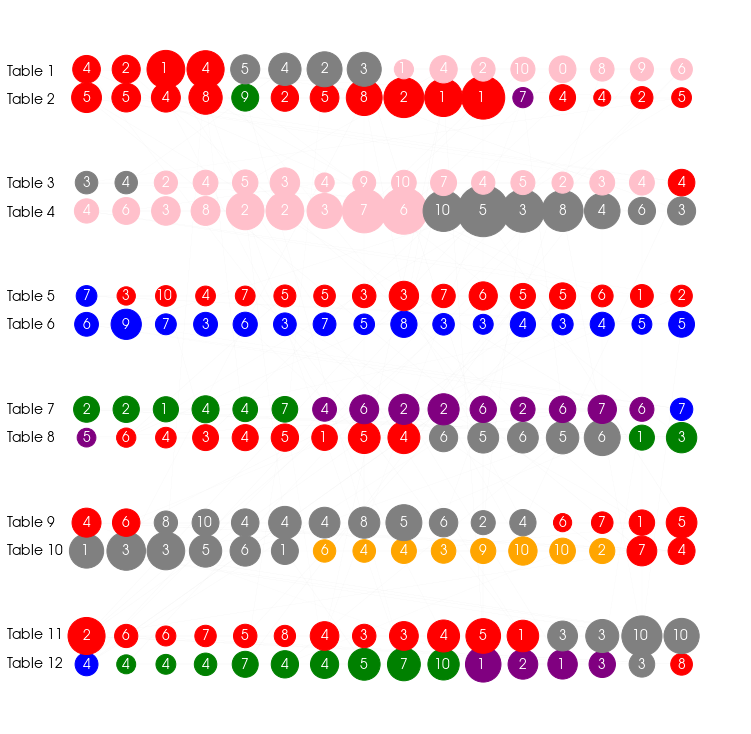

In [74]:
#COLORS FOR GROUPS
#LABELS FOR SENTIMENT
#SIZES FOR eigenvector centrality scores
#EDGES ARE HIDDEN SINCE THEY DO NOT ADD VALUE IN EXPLANATION
fig=plt.figure(figsize=(10,10))
nx.draw(G,
        node_size=200+(2000*np.array(sizes))**1.3,
        width=0.01,
        with_labels=True,
        labels=labels,
        pos=pos,node_color=color_map,
        font_size=14,font_color='w',
        cmap=plt.cm.rainbow)
odd_pos=21.8
odd_title=1
even_pos=20.8
even_title=2
for i in range(6):
    plt.text(x=-2,y =odd_pos, s='Table '+str(odd_title),size=14)
    odd_title+=2
    odd_pos=odd_pos-3.98
for i in range(6):
    plt.text(x=-2,y =even_pos, s='Table '+str(even_title),size=14)
    even_title+=2
    even_pos=even_pos-3.98

**There is convincing evidence that communities form as a result of physical allocation**.

## Examining the similarity of opinions

Define similarity between node pairs that are connected.

In [76]:
similarity={}
for u, v in G.edges():
    key="{}-{}".format(u,v)
    value=np.abs(G.nodes[u]["ai"]-G.nodes[v]["ai"])
    similarity[key]=value

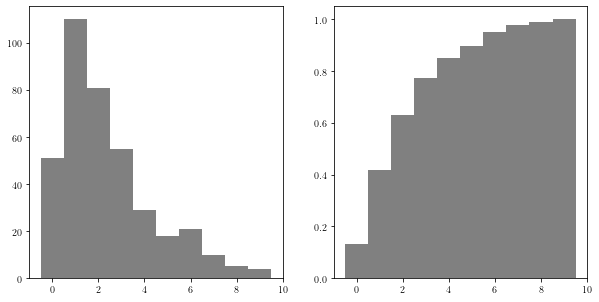

In [77]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 2)
ax1= fig.add_subplot(1, 2, 1)
ax1.hist(similarity.values(),bins=np.arange(11)- 0.5, color='grey')
ax.hist(similarity.values(),bins=np.arange(11)- 0.5, color='grey',
         density=True,
         cumulative=1)
plt.show()

Nearly 80% of all pairs in the network are similar, as indicated by the cumulative histogram above (difference in sentiment less or equal to 4). Around 10% of edges have a score of five or higher. The cumulative probability chart and the standard histogram both indicate that traders communicate primarily with others who share their AI attitudes.

### Does closeness to the floor's centre affect similarity?

In [79]:
from scipy.spatial import distance

In [80]:
dist={}
for u, v in G.edges():
    key="{}-{}".format(u,v)
    dst=distance.euclidean((G.nodes[u]["x_pos"],G.nodes[u]["y_pos"]),
                           (G.nodes[v]["x_pos"],G.nodes[v]["y_pos"]))
    dist[key]=dst

In [102]:
#Find central coordinates of the floor
points=list(pos.values())
x = [p[0] for p in points]
y = [p[1] for p in points]
centroid = (sum(x) / len(points), sum(y) / len(points))

In [103]:
dist_centr=[]
for node in G.nodes():
    dst=distance.euclidean((G.nodes[node]["x_pos"],
                            G.nodes[node]["y_pos"]),centroid)
    dist_centr.append(dst)

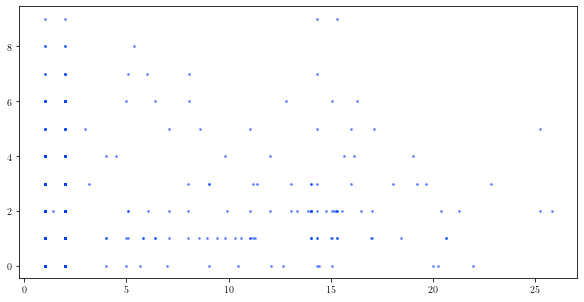

In [84]:
#Does the distance between traders have an impact on their AI similarity?
fig=plt.figure(figsize=(10,5))
plt.scatter(dist.values(),similarity.values(),alpha=0.5,s=3)
plt.show()

**There is no evidence for a strong correlation between node distance and similarity**.

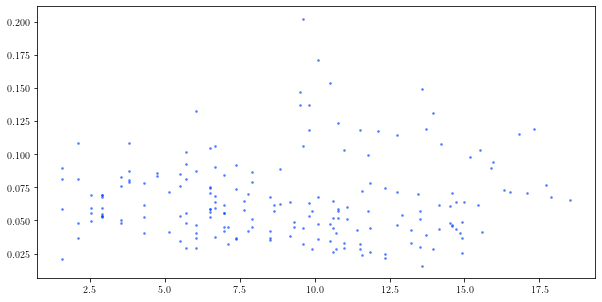

In [109]:
fig=plt.figure(figsize=(10,5))
plt.scatter(dist_centr,ec.values(),alpha=0.5,s=3)
plt.show()

**No evidence is available for a strong correlation between the physical centrality of a node and its eigenvector centrality**.

# What are the network-related obstacles to the spread of positive attitudes toward artificial intelligence on the trading floor?

## Modeling the diffusion of opinions

### The model that divides the network into two categories: AI adopters and non-AI adopters.

In [36]:
#The threshold after which the node becomes adopter
sentiment_tuning=6

In [37]:
#List of adopters with the sentiment above the threshold
early_adopters=[i for i in G.nodes if G.nodes[i]['ai']>sentiment_tuning]

In [38]:
# How many adopters?
len(early_adopters)

41

In [39]:
def diffusion(early_adopters):
    fig=plt.figure(figsize=(18,9))
    g=G
    nodes=g.nodes()
    a = 1
    # --+ pay-off of the status quo (not changing)
    b = 1
    # get degree 'd'
    degree = nx.degree(g)
    # initial state
    # --+ the list of adopters is empty
    adopters = []
    # --+ everybody sticks with the status quo
    #     let's create a node-level attribute reflecting adoption
    for node in g.nodes:
        G.nodes[node]["adopting"] = 0
    # ----+ double-check attributes
    # %% model the diffusion process
    # --+ new adopters
    # --+ expand the set of adopters
    adopters.extend(early_adopters)
    # --+ adopt node attributes
    for adopter in adopters:
        g.nodes[adopter]['adopting'] = 1
    # draw the network
    colors = []
    for n in g.nodes():
        if g.nodes[n]['adopting'] == 1:
            colors.append('orange')
        else:
            colors.append('white')
    plt.subplot(121)
    plt.title('Initial state of the network' +'\n'+ 'with number of adopters of  '+ str(len(early_adopters)))
    #plot the initial network
    nx.draw(g, pos=pos, with_labels=True, node_color=colors,width=0)
    # %% let's simulate what happens in the following periods as nodes make decisions
    steps=-1
    adopted_nodes=[]
    while True :
        steps+=1
        adopted=[]
        for focal in nodes:
            # count adopting neighbors
            focal_nbrs = list(g.neighbors(focal))
            p = np.sum([g.nodes[nbr]['adopting'] for nbr in focal_nbrs])
            # pay-off of adopting new behavior
            d = g.degree(focal)
            a_payoff = p * a
            b_payoff = (d - p ) * b
            # decision to adopt
            if (g.nodes[focal]['adopting'] == 0) & (a_payoff > b_payoff):
                g.nodes[focal]['adopting'] = 1
                adopters.extend(focal)
                adopted.extend(focal)
                adopted_nodes.extend(focal)
            else:
                pass
        colors=[]
        for n in g.nodes():
            if g.nodes[n]['adopting'] == 1:
                colors.append('orange')
            else:
                colors.append('white')
        # stop iterating if there are no new adopters
        if len(adopted)==0:
            plt.subplot(122)
            plt.title('Network after diffusion modelling.' +'\n'+ 'Iterations ran: '+str(steps) +'\n'+ str(len(set(adopted_nodes)))+' nodes were adopted' )
            #plot the network after simulation
            nx.draw(g, pos=pos, with_labels=True, node_color=colors,width=0)
            break

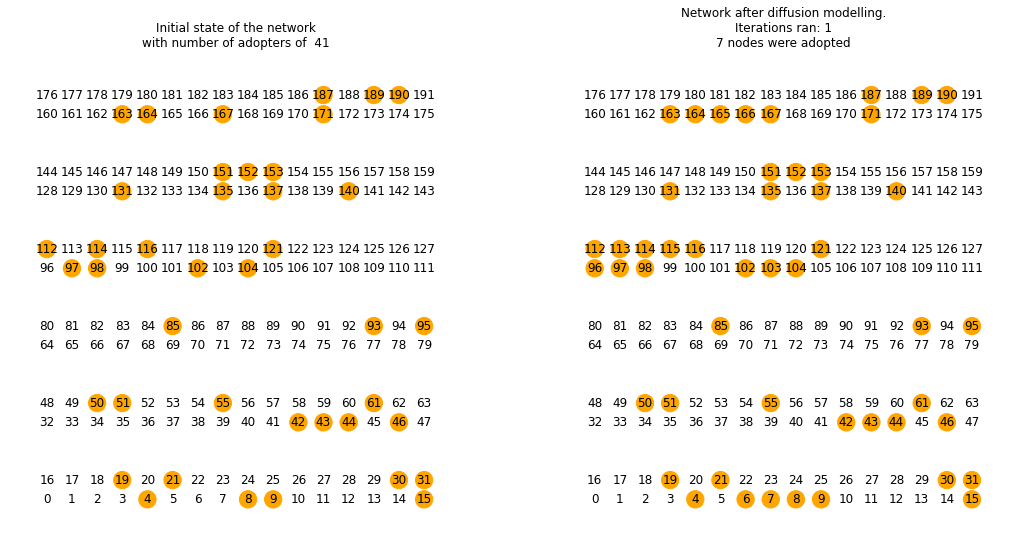

In [40]:
diffusion(early_adopters)

**If 64 nodes (33.5 percent of the network) were chosen to adopt the AI, the network would end up with 38.5 percent adopted nodes**

For example, if 41 were chosen (sentiment tuning=6), only 7 nodes would become adopters after the first iteration.

In [41]:
df=df.sort_values(by='eigenvector centrality', ascending=False)

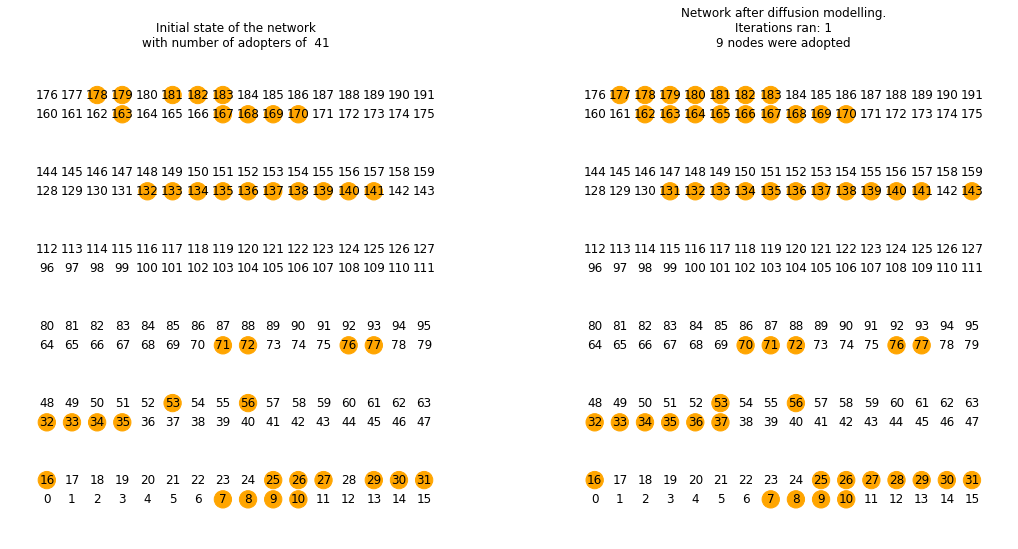

In [42]:
#What if persuading influencers to become adopters?
n=41
influencial_adopters=df[:n].index
diffusion(influencial_adopters)

**Selecting the 64 most influential nodes would result in the adoption of the same number (10) of new nodes. Choosing 41 - 9. It reveals that nodes with the highest e_c scores do not contribute significantly to the adoption of more nodes**.

 ### The model that is based on the assumption that nodes are judgemental.

In [164]:
def diffusion_mod(network,
#How much will the node adjust its opinion based on the opinions of its neighbours? 0 to 1 scale
                  social_orientation_extent=1,
#How different should the focal node's neighbours' opinions 
#be for the focal node to consider changing its mind?
                  opinion_breaking_point=1,
#list of nodes with fixed opinions
                 fixed_opinions=[]):
    g=network.copy()
    ai_attribs=np.array(list(nx.get_node_attributes(g,'ai').values()))
    average_before=np.mean(ai_attribs)
    count_changes=0
    while True:
        total_change = 0
        for node in g.nodes:
            if node not in fixed_opinions:
                node_nbrs = list(g.neighbors(node))
                total = 0
                for nbr in node_nbrs:
                    total += g.nodes[nbr]["ai"]
                avg_opinion = total / len(node_nbrs)
                delta = abs(avg_opinion - g.nodes[node]["ai"])
                if delta>opinion_breaking_point:
                    #compare current and potential opinion of the node
                    next_opinion = social_orientation_extent*avg_opinion
                    #the opinion can not go beyond 0 and 10
                    if next_opinion>=0 and next_opinion<=10:
                        count_changes+=1
                        #moment of opinion change
                        g.nodes[node]["next"] = next_opinion
                    else:
                        g.nodes[node]["next"] = g.nodes[node]["ai"]
                else:
                    g.nodes[node]["next"]= g.nodes[node]["ai"]
            else:
                g.nodes[node]["next"] = g.nodes[node]["ai"]
        total_change +=  abs(g.nodes[node]["ai"] - g.nodes[node]["next"])
        #stop the diffusion process if nodes stop changing their opinions
        if total_change==0:
            break 
        for node in g.nodes:
            g.nodes[node]["ai"] = g.nodes[node]["next"]
    ai_attribs_after_diffusion=np.array(list(nx.get_node_attributes(g,'next').values()))
    average_after=np.mean(ai_attribs_after_diffusion)
    print('opinions changed '+str(count_changes)+' times')
    print('average sentiment before the diffusion was '+str(average_before))
    print('average sentiment after the diffusion is '+str(average_after))
    print('percentage change is '+str(average_after/average_before-1))

In [165]:
#What will happen if no action is taken?
G_init=G.copy()
diffusion_mod(G_init,
              social_orientation_extent=1,
              opinion_breaking_point=1)

opinions changed 118 times
average sentiment before the diffusion was 4.6875
average sentiment after the diffusion is 4.650049603174604
percentage change is -0.00798941798941788


In [177]:
#What if persuading 41 influencers to distribute a max positive opinion?
#But assuming they could be influenced by others
g_influencers=G.copy()
for node in g_influencers:
    if node in influencial_adopters:
        g_influencers.nodes[node]["ai"]=10
diffusion_mod(g_influencers)

opinions changed 127 times
average sentiment before the diffusion was 5.869791666666667
average sentiment after the diffusion is 6.095833333333334
percentage change is 0.03850931677018643


Even if 41 of the network's most influential nodes held the most positive views, the spread of positive sentiment would be limited (it would change by around 3-4 percent )

In [180]:
#What if changing 41 nodes nodes with least opinion to 10?
k=41
df=df.sort_values(by='ai_attribs', ascending=True)
#list of most negative-sentiment nodes
negative_nodes=df[:k].index
g_mod=G.copy()
for node in g_mod:
    if node in negative_nodes:
        g_mod.nodes[node]["ai"]=10
diffusion_mod(g_mod)

opinions changed 138 times
average sentiment before the diffusion was 6.447916666666667
average sentiment after the diffusion is 6.365811011904761
percentage change is -0.012733671820909565


This scenario demonstrates that by increasing the sentiment of the most 'negative' nodes without taking their centrality into account, the diffusion will not result in more positive sentiment in the network.

In [181]:
from sklearn.utils import shuffle
#Let's find out the relationship between the number of enthusiasts randomly picked and the outcome of the diffusion
for k in range (1,193):
    g_consensus=G.copy()
    df = shuffle(df)
    consensus_nodes=df[:k].index
    print(k)
    for node in g_consensus.nodes:
        if node in consensus_nodes:
            g_consensus.nodes[node]["ai"]=10
    diffusion_mod(g_consensus)

1
opinions changed 117 times
average sentiment before the diffusion was 4.734375
average sentiment after the diffusion is 4.677393353174604
percentage change is -0.012035727382261885
2
opinions changed 118 times
average sentiment before the diffusion was 4.697916666666667
average sentiment after the diffusion is 4.656820436507936
percentage change is -0.008747756308732035
3
opinions changed 118 times
average sentiment before the diffusion was 4.796875
average sentiment after the diffusion is 4.734771825396826
percentage change is -0.012946590145287096
4
opinions changed 120 times
average sentiment before the diffusion was 4.765625
average sentiment after the diffusion is 4.71906001984127
percentage change is -0.00977101223002863
5
opinions changed 118 times
average sentiment before the diffusion was 4.854166666666667
average sentiment after the diffusion is 4.8263516865079366
percentage change is -0.005730124667892911
6
opinions changed 127 times
average sentiment before the diffusion 

**While nodes' opinions change frequently, there is no significant improvement in the network's average sentiment score**.

Possible explanations include the following:
1) As previously stated, there is a high degree of opinion similarity, which acts as a barrier to sentiment change.

2) Communities have a negative impact on the spread of new ideas.

**Does it have a way to be challenged?**

I can think of two possible solutions:

a) To maximise the spread of positive opinions, nodes should be rearranged and communicate with new nodes so that their average sentiment is significantly higher than that of the focal node.

b) If there is a way to motivate traders not to change their opinions based on the opinions of others, diffusion would aid in the spread of positive opinions.

In [179]:
#Let's find out the relationship between the number of enthusiasts ('ai'==10) and outcome of the diffusion
#if assigning '10' 'ai' scores randomly and fixing their opinions
for k in range (1,193):
    g_consensus_fixed=G.copy()
    randomly_motivated.append(k)
    df = shuffle(df)
    consensus_nodes=df[:k].index
    for node in g_consensus_fixed.nodes:
        if node in consensus_nodes:
            g_consensus_fixed.nodes[node]["ai"]=10
    diffusion_mod(g_consensus_fixed,fixed_opinions=consensus_nodes)

1
opinions changed 117 times
average sentiment before the diffusion was 4.71875
average sentiment after the diffusion is 4.6981398809523816
percentage change is -0.004367707347839644
2
opinions changed 119 times
average sentiment before the diffusion was 4.75
average sentiment after the diffusion is 4.803174603174603
percentage change is 0.011194653299916313
3
opinions changed 121 times
average sentiment before the diffusion was 4.75
average sentiment after the diffusion is 4.7997023809523816
percentage change is 0.01046365914786973
4
opinions changed 121 times
average sentiment before the diffusion was 4.822916666666667
average sentiment after the diffusion is 4.895535714285715
percentage change is 0.015057081147793916
5
opinions changed 121 times
average sentiment before the diffusion was 4.833333333333333
average sentiment after the diffusion is 4.937636408730159
percentage change is 0.02157994663382623
6
opinions changed 115 times
average sentiment before the diffusion was 4.869791

In [184]:
#Let's find out the relationship between the number of enthusiasts ('ai'==10) and outcome of the diffusion
#if assigning 10 scores to most central nodes and fixing their opinions
df=df.sort_values(by='eigenvector centrality', ascending=False)
for k in range (1,193):
    g_consensus_fixed=G.copy()
    print(k)
    influencial_adopters=df[:k].index
    for node in g_consensus_fixed:
        if node in influencial_adopters:
            g_consensus_fixed.nodes[node]["ai"]=10
    diffusion_mod(g_consensus_fixed,fixed_opinions=influencial_adopters)

1
opinions changed 116 times
average sentiment before the diffusion was 4.713541666666667
average sentiment after the diffusion is 4.706163194444445
percentage change is -0.001565377532228407
2
opinions changed 116 times
average sentiment before the diffusion was 4.734375
average sentiment after the diffusion is 4.75546875
percentage change is 0.004455445544554459
3
opinions changed 115 times
average sentiment before the diffusion was 4.75
average sentiment after the diffusion is 4.802864583333334
percentage change is 0.01112938596491242
4
opinions changed 114 times
average sentiment before the diffusion was 4.796875
average sentiment after the diffusion is 4.886545138888889
percentage change is 0.01869344914947524
5
opinions changed 112 times
average sentiment before the diffusion was 4.833333333333333
average sentiment after the diffusion is 4.946180555555555
percentage change is 0.023347701149425415
6
opinions changed 112 times
average sentiment before the diffusion was 4.84375
aver